##  DNA curtain finder part 2
----
[DNA_curtain_finder part_1](https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/5__DNA_curtain_finder_1.ipynb)

[DNA_curtain_finder part_2](https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/6__DNA_curtain_finder_2.ipynb)

[DNA_curtain_finder part_3](https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/7__DNA_curtain_finder_3.ipynb)


This notebook begins where `DNA_curtain_finder_1` left off, is the second in a series of three, and will describe the first part of the method we are using to locate individual DNA strands within each of our DNA curtains. The first thing we do is bring in the two definitions from the `DNA_curtain_finder_1` notebook:
* find_rotang
* find_curtain




In [1]:
#Dependencies
import smtools.alignment as al
from skimage.external.tifffile import imread
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from skimage.exposure import equalize_adapthist
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage.interpolation import rotate
from matplotlib.patches import Rectangle


import os
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

def find_rotang(Image, line_length = 40,
                theta = None, line_gap = 5, tilt = .1):
    if theta is None:
        theta = np.linspace(np.pi/2.-tilt, np.pi/2.+tilt, 500)
        
    edges = canny(equalize_adapthist(Image))
    lines = probabilistic_hough_line(edges,line_length=line_length,
                                     theta=theta,line_gap=line_gap)
    
    rise = [line[1][1]-line[0][1] for line in lines]
    run = [line[1][0]-line[0][0] for line in lines]
    rotation = 180*np.tan(np.mean(rise)/np.mean(run))/np.pi
    return rotation

def find_curtain(Image, distance = 50, line_length = 40, 
                   theta = None, line_gap = 5, tilt = .1, 
                   window = 15, order = 3, maxline = 70):

    if theta is None:
        theta = np.linspace(np.pi/2.-tilt, np.pi/2.+tilt, 500)
        
    edges = canny(equalize_adapthist(Image))
    lines = probabilistic_hough_line(edges,line_length=line_length,
                                     theta=theta,line_gap=line_gap)
    
    line_starts = [line[0][0] for line in lines]
    line_ends = [line[1][0] for line in lines]
    x = np.linspace(0,Image.shape[1]+1,Image.shape[1]+1)
    starts,bins = np.histogram(line_starts,bins=x)
    ends,bins = np.histogram(line_ends,bins=x)
    smoothed_starts = savgol_filter(starts, window, order)
    smoothed_ends = savgol_filter(ends, window, order)
    peaks_start, _ = find_peaks(smoothed_starts, distance = distance)
    peaks_end, _ = find_peaks(smoothed_ends, distance = distance)
    curtains = []
    for j in peaks_start:
        for k in peaks_end:
            if (abs(j-k)>line_length and abs(j-k)<line_length+20 
                and smoothed_starts[j]>1. and smoothed_ends[k]>1.):
                curtains.append((j,k))    
    d = {key[0]:[] for key in curtains}
    for line in lines:
        key = min(peaks_start, key=lambda x:abs(x-line[0][0]))
        if line[1][0]-line[0][0]<maxline:
            try:
                d[key].append(line[0][1])
            except KeyError:
                pass
    data = []
    curtain_mask = np.ones_like(Image, dtype=bool)
    for m, n in zip(d, curtains):
        x_min = min(np.clip([n[0]-10], 0, rotated_ch2.shape[1]))
        x_max = max(np.clip([n[1]+10], 0, rotated_ch2.shape[1]))
        y_min = min(np.clip([x-5 for x in d[m]], 0, rotated_ch2.shape[0]))
        y_max = max(np.clip([x+5 for x in d[m]], 0, rotated_ch2.shape[0]))
        
        data.append((x_min, x_max, y_min, y_max))
        curtain_mask[y_min:y_max,x_min:x_max] = False

    return data, curtain_mask


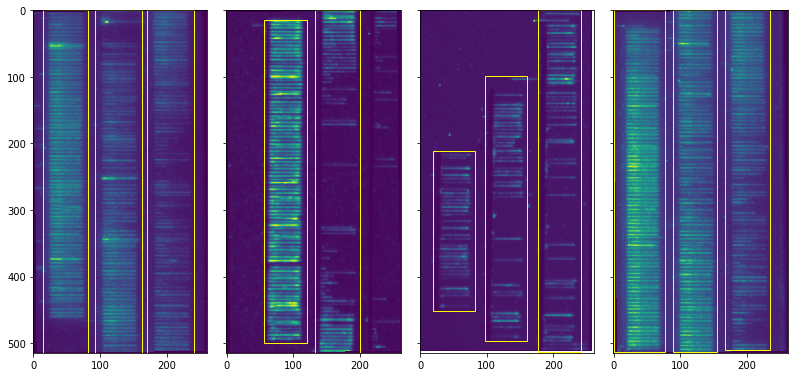

In [2]:
im_list = []
for i in os.listdir("test_images/"):
    if i.endswith("tif"):
        im_list.append(imread("test_images/"+i))


fig, subplots = plt.subplots(1,4,figsize =(11,5),
                             constrained_layout=True, 
                             sharex = True, sharey = True)
for i,ax in zip(im_list, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)

    ax.imshow(rotated_ch2)
    for j in bounds:
        ax.add_patch(Rectangle((j[0],j[2]),j[1]-j[0],j[3]-j[2],fill=False, color = "yellow"))
plt.show()

Okay, we are going start by getting the general location of each DNA strand within inside of these boxes. Later we will be more accurate, but for now, we will do the following steps:

* Take vertical line scans through each bounding box
* Find the peaks in those scans with scipy.signal.find_peaks
* Then flatten all of the located peaks along the DNA dimension into a single summed trace
* Then find the peaks in the flattened trace, again with scipy.signal.find_peaks
* Finally, a DNA is "detected" if there is an assigned peak determined from the flattened trace 

To start, lets get an idea of what these line scans will look like, and how well find_peaks will perform.

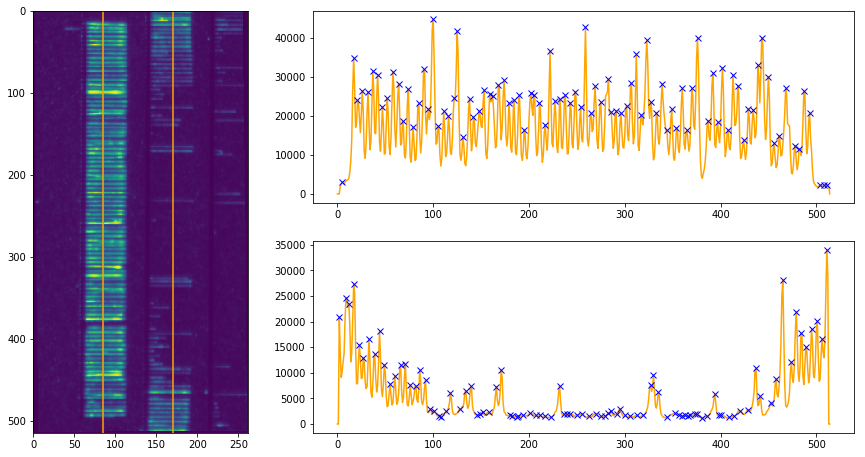

In [3]:
import matplotlib.gridspec as gridspec

img = im_list[1]
ch1,ch2 = al.im_split(img)
angle = find_rotang(ch2)
rotated_ch2 = rotate(ch2,angle)

fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(3, 3)

ax = fig.add_subplot(gs[:-1, 0])
ax.imshow(rotated_ch2)
ax.axvline(x=85, color = "orange")
ax.axvline(x=170, color = "orange")

ax1 = fig.add_subplot(gs[0, 1:])
subim = rotated_ch2[:,85]
ax1.plot(subim, color = "orange")
peaks, properties = find_peaks(subim)
ax1.plot(peaks, subim[peaks], "bx")
ax2 = fig.add_subplot(gs[1, 1:])
subim = rotated_ch2[:,170]
ax2.plot(subim, color = "orange")
peaks, properties = find_peaks(subim)
ax2.plot(peaks, subim[peaks], "bx")

plt.show()


Okay, not too shabby. The detecter is certainly finding a fair number of peaks where there aren't any DNAs, but its doing a pretty good job where there are DNAs. So, a little of this, a little of that. I would like to think that if we average across the DNA dimension of the curtain, the "bad" peaks will mostly blur out, and the "real" peaks will get stronger. To see if that's likely, lets have a look at how well it does on all of the DNA curtain regions.

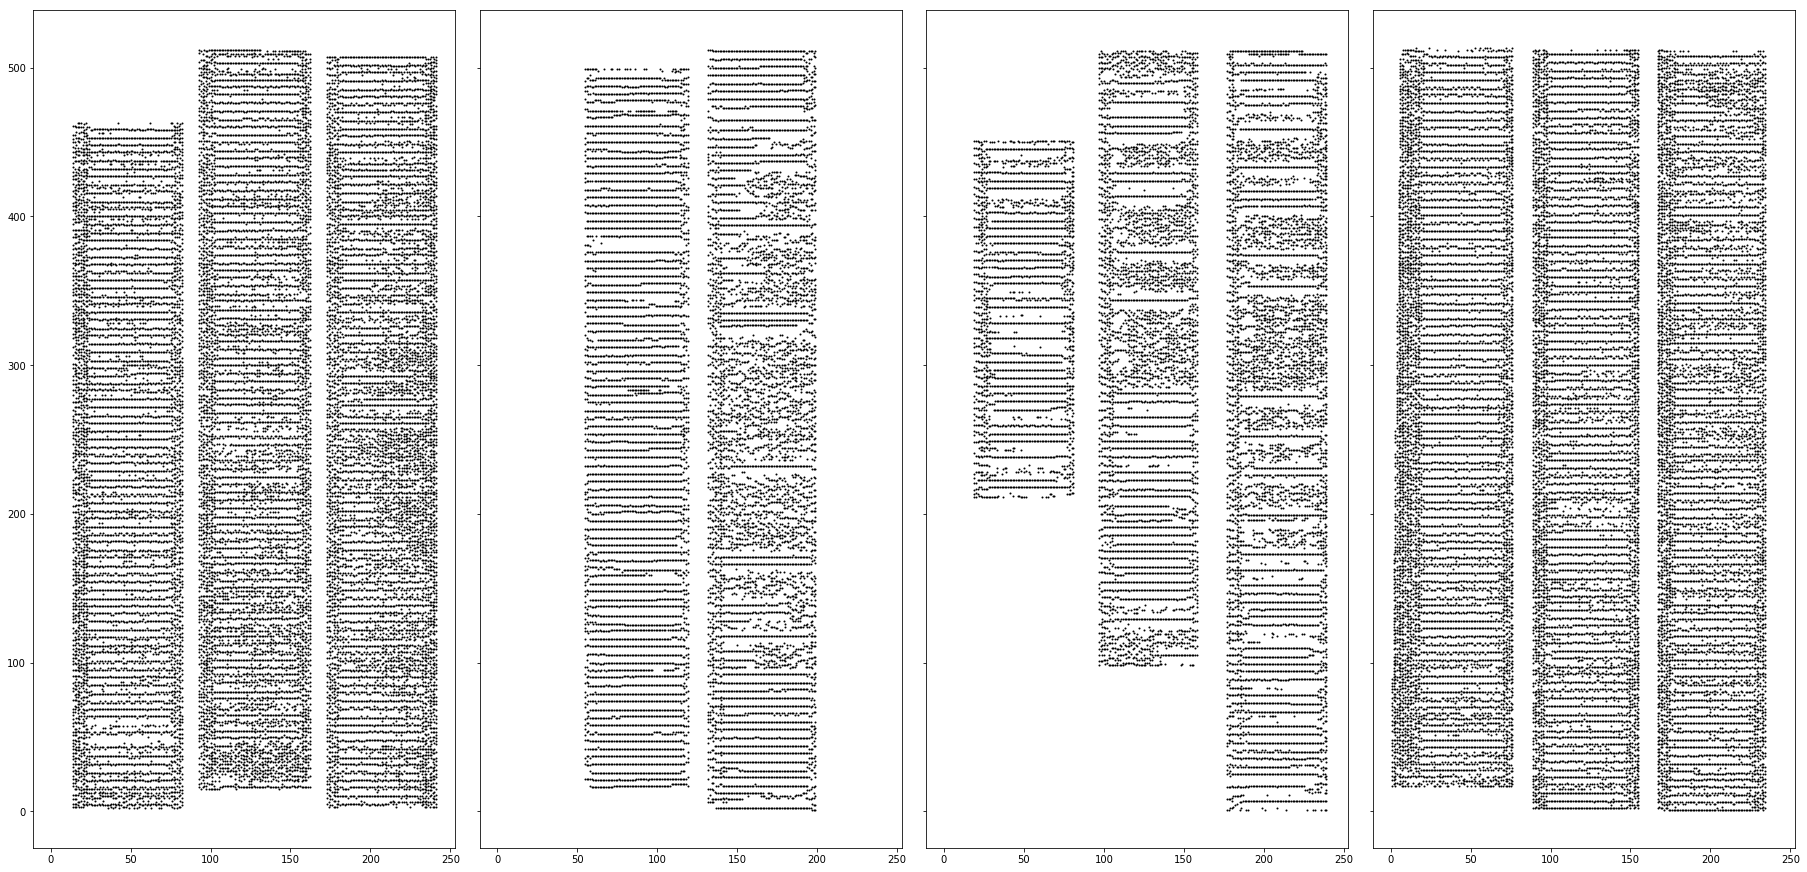

In [4]:
fig, subplots = plt.subplots(1,4,figsize=(25,12),
                             constrained_layout=True, 
                             sharex = True, sharey = True)

for i,ax in zip(im_list, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)
    rotated_ch2[mask] = 0
    for j in range(rotated_ch2.shape[1]):
        subim = rotated_ch2[:,j] 
        peaks, properties = find_peaks(subim)
        ax.plot([j for k in peaks],peaks, "ko", markersize = 1)
        
plt.show()


That looks pretty great! Now I'm going to flatten each box (each curtain) by summing along the DNA axis, and then I'll use `find_peaks` again and see how that does.

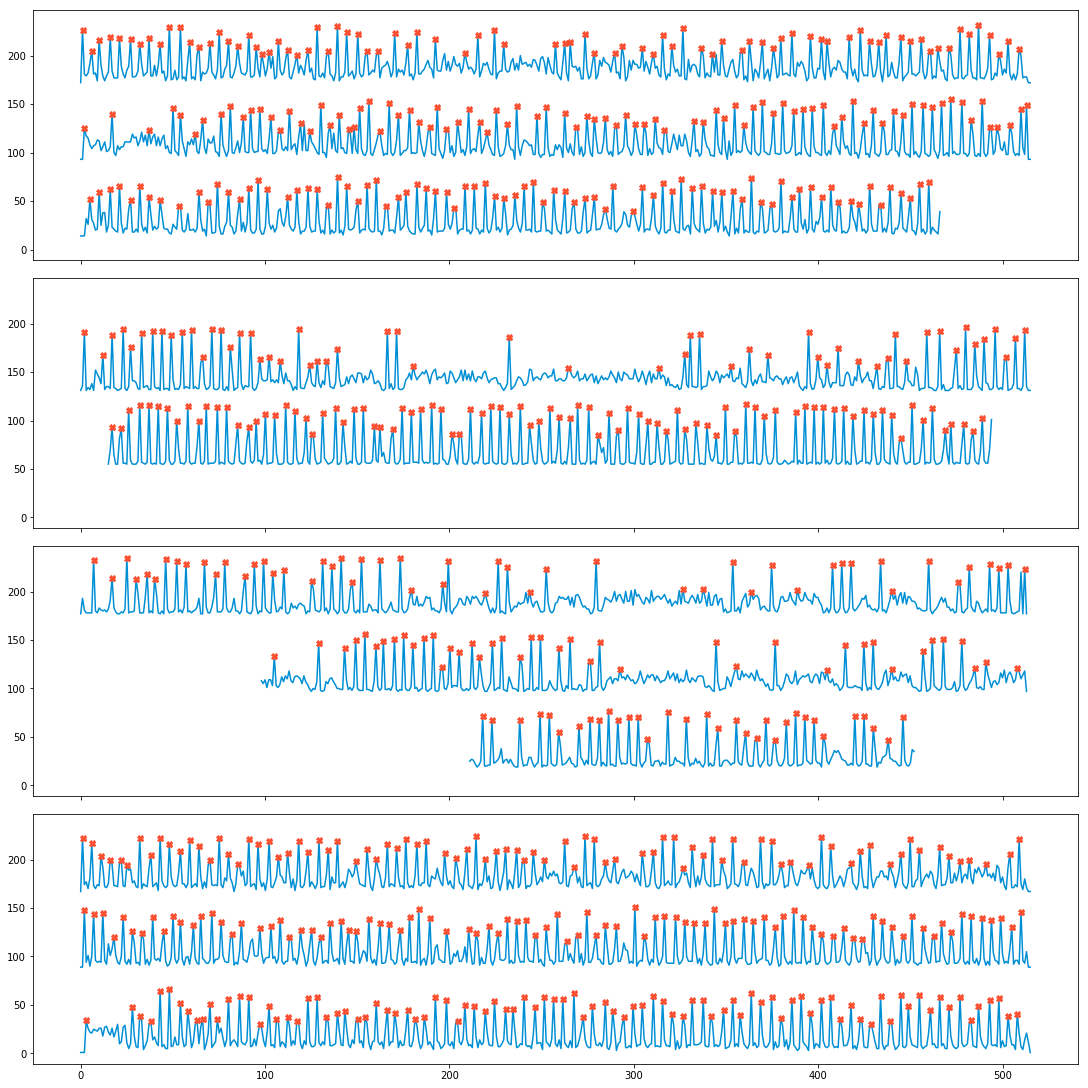

In [6]:
im_list = []
for i in os.listdir("test_images/"):
    if i.endswith("tif"):
        im_list.append(imread("test_images/"+i))


fig, subplots = plt.subplots(4,1,figsize=(15,15),
                             constrained_layout=True, 
                             sharex = True, sharey = True)


for i, ax in zip(im_list, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)
    
    point_im = np.zeros_like(rotated_ch2, dtype=bool)
    for j in range(rotated_ch2.shape[1]):
        subim = rotated_ch2[:,j]
        peaks, properties = find_peaks(subim)
        for k in peaks:
            point_im[k,j]=True
    
    detected_im = np.zeros_like(rotated_ch2, dtype=bool)
    for j in bounds:
        subarr = point_im[j[2]:j[3],j[0]:j[1]]
        flattened = []
        for k in range(len(subarr)):
            flattened.append(j[0]+sum(subarr[k,:]))
        peaks, properties = find_peaks(flattened, distance = 3, prominence = (20, 1.5*max(flattened)))
        ydata = np.linspace(j[2],j[3], j[3]-j[2])
        ax.plot(ydata,flattened, "#008fd5")
        ax.plot(ydata[peaks], np.array(flattened)[peaks], "#fc4f30", marker = "X", linestyle='None')

            
plt.show()



Okay, lets get all of this into a single definition for easy use.

In [8]:
def find_DNA(Image, Bounds, prominence = None):
    
    data = []
    point_im = np.zeros_like(Image, dtype=bool)
    for i in range(Image.shape[1]):
        subim = Image[:,i]
        peaks, properties = find_peaks(subim)
        for j in peaks:
            point_im[j,i]=True   
    detected_im = np.zeros_like(Image, dtype=bool)
    for i in Bounds:
        subarr = point_im[i[2]:i[3],i[0]:i[1]]
        flattened_arr = [sum(subarr[j,:]) for j in range(len(subarr))]
        if prominence is None:
            prominence = (20, 1.5*max(flattened_arr))
        peaks, properties = find_peaks(flattened_arr, distance = 3, prominence = prominence)
        for j in peaks:
            data.append((i[0],i[1],i[2]+j))     
    return data

            
            

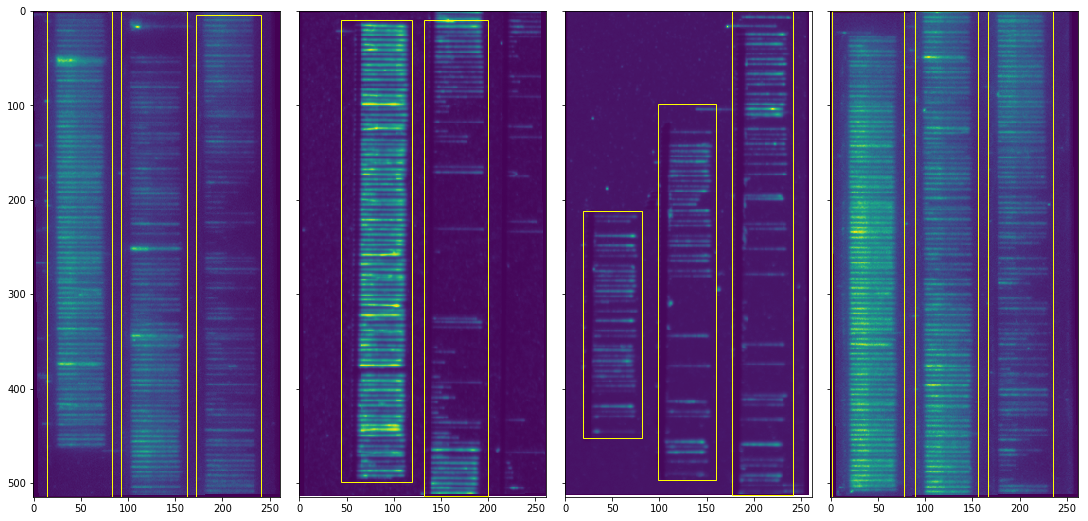

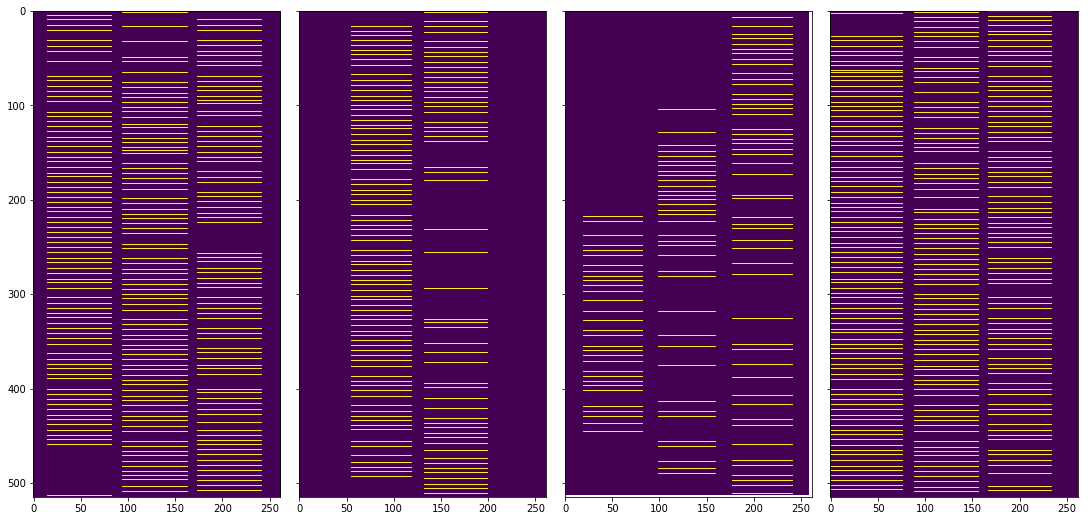

In [10]:
im_list = []
for i in os.listdir("test_images/"):
    if i.endswith("tif"):
        im_list.append(imread("test_images/"+i))


fig, subplots = plt.subplots(1,4,figsize =(15,10),
                             constrained_layout=True, 
                             sharex = True, sharey = True)
for i,ax in zip(im_list, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)

    ax.imshow(rotated_ch2)
    for j in bounds:
        ax.add_patch(Rectangle((j[0],j[2]),j[1]-j[0],j[3]-j[2],fill=False, color = "yellow"))



fig, subplots = plt.subplots(1,4,figsize=(15,10),
                             constrained_layout=True, 
                             sharex = True, sharey = True)

for i, ax in zip(im_list, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)
    strands = find_DNA(rotated_ch2,bounds)
    detected_im = np.zeros_like(rotated_ch2, dtype=bool)
    for j in strands:
        detected_im[j[2],j[0]:j[1]] = True
    ax.imshow(detected_im)

Alright, that's where we will leave this notebook off at. The next step will be to fit the intensity profile of each individual DNA strand. And, for that, go to the `DNA_curtain_finder_3` notebook.